In [1]:
import os
import glob
import random
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
from types import SimpleNamespace
import albumentations as A
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
# import timm
import pydicom

def set_seed(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

/home/sonujha/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def convert_to_8bit(x):
    lower, upper = np.percentile(x, (1, 99))
    x = np.clip(x, lower, upper)
    x = x - np.min(x)
    x = x / np.max(x) 
    return (x * 255).astype("uint8")


def load_dicom_stack(dicom_folder, plane, reverse_sort=False):
    dicom_files = glob.glob(os.path.join(dicom_folder, "*.dcm"))
    dicoms = [pydicom.dcmread(f) for f in dicom_files]
    plane = {"sagittal": 0, "coronal": 1, "axial": 2}[plane.lower()]
    positions = np.asarray([float(d.ImagePositionPatient[plane]) for d in dicoms])
    # if reverse_sort=False, then increasing array index will be from RIGHT->LEFT and CAUDAL->CRANIAL
    # thus we do reverse_sort=True for axial so increasing array index is craniocaudal
    idx = np.argsort(-positions if reverse_sort else positions)
    ipp = np.asarray([d.ImagePositionPatient for d in dicoms]).astype("float")[idx]
    array = np.stack([d.pixel_array.astype("float32") for d in dicoms])
    array = array[idx]
    return {"array": convert_to_8bit(array), "positions": ipp, "pixel_spacing": np.asarray(dicoms[0].PixelSpacing).astype("float")}


In [3]:
 resize_transform= A.Compose([
    A.LongestMaxSize(max_size=256, interpolation=cv2.INTER_CUBIC, always_apply=True),
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0), always_apply=True),
])

def angle_of_line(x1, y1, x2, y2):
    return math.degrees(math.atan2(-(y2-y1), x2-x1))       

In [4]:
def plot_img(img, coords_temp):
    # Plot img
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    h, w = img.shape
    
    # Kepoints as pairs
    p= coords_temp.groupby("level") \
                  .apply(lambda g: list(zip(g['relative_x'], g['relative_y'])), include_groups=False) \
                  .reset_index(drop=False, name="vals")
    
    # Plot keypoints
    for _, row in p.iterrows():
        level = row['level']
        x = [_[0]*w for _ in row["vals"]]
        y = [_[1]*h for _ in row["vals"]]
        ax.plot(x, y, marker='o')
    ax.axis('off')
    plt.show()

def plot_5_crops(img, coords_temp):
    # Create a figure and axis for the grid
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(1, 5, width_ratios=[1]*5)
    
    # Plot the crops
    p= coords_temp.groupby("level").apply(lambda g: list(zip(g['relative_x'], g['relative_y'])), include_groups=False).reset_index(drop=False, name="vals")
    for idx, (_, row) in enumerate(p.iterrows()):
        # Copy of img
        img_copy= img.copy()
        h, w = img.shape

        # Extract Keypoints
        level = row['level']
        vals = sorted(row["vals"], key=lambda x: x[0])
        a,b= vals
        a= (a[0]*w, a[1]*h)
        b= (b[0]*w, b[1]*h)

        # Rotate
        rotate_angle= angle_of_line(a[0], a[1], b[0], b[1])
        transform = A.Compose([
            A.Rotate(limit=(-rotate_angle, -rotate_angle), p=1.0),
        ], keypoint_params= A.KeypointParams(format='xy', remove_invisible=False),
        )

        t= transform(image=img_copy, keypoints=[a,b])
        img_copy= t["image"]
        a,b= t["keypoints"]
        
        # Crop + Resize
        img_copy= crop_between_keypoints(img_copy, a, b)
        img_copy= resize_transform(image=img_copy)["image"]
        
        # Plot
        ax = plt.subplot(gs[idx])
        ax.imshow(img_copy, cmap='gray')
        ax.set_title(level)
        ax.axis('off')
    plt.show()

In [5]:
def crop_between_keypoints(img, keypoint1, keypoint2):
    h, w = img.shape
    x1, y1 = int(keypoint1[0]), int(keypoint1[1])
    x2, y2 = int(keypoint2[0]), int(keypoint2[1])
    
    # Calculate bounding box around the keypoints
    left = int(min(x1, x2))
    right = int(max(x1, x2))
    top = int(min(y1, y2) - (h * 0.1))
    bottom = int(max(y1, y2) + (h * 0.1))
            
    # Crop the image
    return img[top:bottom, left:right]

In [13]:
SEED= 12
N= 2

# Load series_id

dfd= pd.read_csv("../data/train_series_descriptions.csv")
dfd= dfd[dfd.series_description == "Sagittal T2/STIR"]
dfd= dfd.sample(frac=1, random_state=SEED).head(N)

# Load coords
coords= pd.read_csv("../tmp/coords_rsna_improved.csv")
coords= coords.sort_values(["series_id", "level", "side"]).reset_index(drop=True)
coords= coords[["series_id", "level", "side", "relative_x", "relative_y"]]

In [16]:
image_dir = '../data/train_images/'

In [18]:
sag_t2 = load_dicom_stack(os.path.join(image_dir, str(row.study_id), str(row.series_id)), plane="sagittal")

In [23]:
sag_t2.keys()

dict_keys(['array', 'positions', 'pixel_spacing'])

In [25]:
sag_t2['positions']

array([[-46.24116135, -96.75544736,  58.11138017],
       [-41.84116364, -96.75544736,  58.11138017],
       [-37.44116211, -96.75544736,  58.11138017],
       [-33.04116058, -96.75544736,  58.11138017],
       [-28.64116287, -96.75544736,  58.11138017],
       [-24.24116135, -96.75544736,  58.11138017],
       [-19.84116173, -96.75544736,  58.11138017],
       [-15.44116211, -96.75544736,  58.11138017],
       [-11.04116249, -96.75544736,  58.11138017],
       [ -6.6411624 , -96.75544736,  58.11138017],
       [ -2.2411623 , -96.75544736,  58.11138017],
       [  2.1588378 , -96.75544736,  58.11138017],
       [  6.55883789, -96.75544736,  58.11138017],
       [ 10.95883751, -96.75544736,  58.11138017],
       [ 15.35883808, -96.75544736,  58.11138017],
       [ 19.75883865, -96.75544736,  58.11138017],
       [ 24.15883827, -96.75544736,  58.11138017]])

-------------------------  STUDY_ID: 4016995268, SERIES_ID: 2259028760  -------------------------
{'array': array([[[ 6,  5,  4, ...,  0,  0,  0],
        [ 7, 11, 12, ...,  0,  0,  0],
        [ 4, 11,  9, ...,  0,  0,  0],
        ...,
        [ 5,  9, 11, ...,  0,  0,  0],
        [ 6,  8, 11, ...,  0,  0,  0],
        [ 4,  3,  3, ...,  0,  0,  0]],

       [[ 6,  3,  6, ...,  0,  0,  0],
        [ 4, 13,  9, ...,  0,  0,  0],
        [ 4, 15,  7, ...,  0,  0,  0],
        ...,
        [ 6, 11, 17, ...,  0,  0,  0],
        [ 5,  6, 20, ...,  0,  0,  0],
        [ 7,  4,  4, ...,  0,  0,  0]],

       [[ 6,  5,  5, ...,  0,  0,  0],
        [ 9, 15, 17, ...,  0,  0,  0],
        [ 8,  9, 10, ...,  0,  0,  0],
        ...,
        [ 3, 10, 11, ...,  0,  0,  0],
        [ 6, 10, 14, ...,  0,  0,  0],
        [ 5,  3,  3, ...,  0,  0,  0]],

       ...,

       [[21, 21, 20, ...,  0,  0,  0],
        [28, 40, 45, ...,  0,  0,  0],
        [25, 36, 44, ...,  0,  0,  0],
        ...,
  

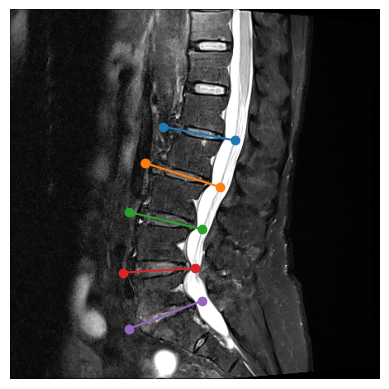

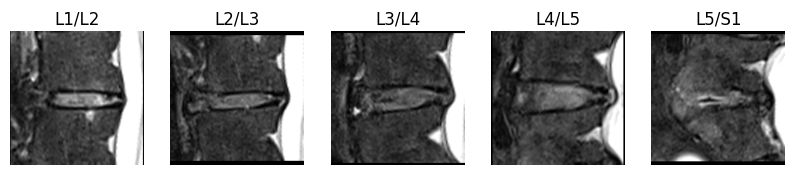

-------------------------  STUDY_ID: 1723430291, SERIES_ID: 1781097800  -------------------------
{'array': array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 9, 4, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 3, 4, ..., 0, 0, 0],
        ...,
        [0, 1, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 2, 2, ..., 0, 0, 0],
        [0, 3, 3, ..., 0, 0, 0],
        ...,
        [0, 2, 1, ..., 0, 0, 0],
        [0, 2, 3, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 1, 1, ..., 0, 0, 0],
        [0, 6, 4, ..., 0, 0, 0],
        [0, 7, 5, ..., 0, 0, 0],
        ...,
        [0, 3, 2, ..., 0, 0, 0],
        [0, 3, 2, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0

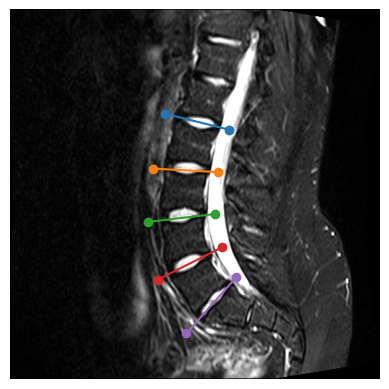

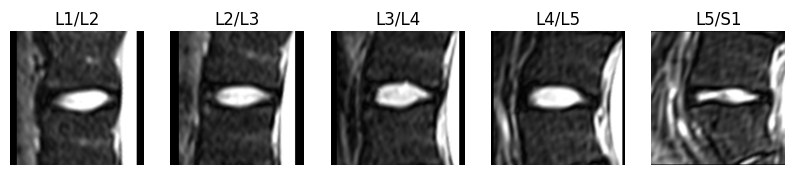

In [17]:
 # Plot samples
for idx, row in dfd.iterrows():
    try:
        print("-"*25, " STUDY_ID: {}, SERIES_ID: {} ".format(row.study_id, row.series_id), "-"*25)
        sag_t2 = load_dicom_stack(os.path.join(image_dir, str(row.study_id), str(row.series_id)), plane="sagittal")
        print(sag_t2)
       
        # Img + Coords
        img= sag_t2["array"][len(sag_t2["array"])//2]
        coords_temp= coords[coords["series_id"] == row.series_id].copy()
        
        # Plot
        plot_img(img, coords_temp)
        plot_5_crops(img, coords_temp)

    except Exception as e:
        print(e)
        pass